### Business Problem

A person’s creditworthiness is often associated (conversely) with the likelihood they may default on loans. 

We’re giving you anonymized data on about 1000 loan applications, along with a certain set of attributes about the applicant itself, and whether they were considered high risk.

0 = Low credit risk i.e high chance of paying back the loan amount

1 = High credit risk i.e low chance of paying back the loan amount

### Business Constraint: 
Note that it is worse to state an applicant as a low credit risk when they are actually a high risk, than it is to state an applicant to be a high credit risk when they aren’t.

### key performance metric 
recall \
f1score

In [650]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier,SGDRegressor
from sklearn.metrics import f1_score,r2_score,confusion_matrix,recall_score,f1_score,precision_score,roc_auc_score,precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
import prettytable

In [651]:
applicant=pd.read_csv('data/applicant.csv') #loading data
loan=pd.read_csv('data/loan.csv')

In [655]:
data=pd.merge(loan,applicant,on='applicant_id') #join
data.drop(['loan_application_id', 'applicant_id'],axis=1,inplace=True)  #drop

### Correlation matrix

In [656]:
numerical_feature =['Months_loan_taken_for','Principal_loan_amount','Primary_applicant_age_in_years']

categorical_feature=['Purpose',
 'EMI_rate_in_percentage_of_disposable_income',
 'Property',
 'Has_coapplicant',
 'Has_guarantor',
 'Other_EMI_plans',
 'Number_of_existing_loans_at_this_bank',
 'Loan_history',
 'Gender',
 'Marital_status',
 'Number_of_dependents',
 'Housing',
 'Years_at_current_residence',
 'Employment_status',
 'Has_been_employed_for_at_least',
 'Has_been_employed_for_at_most',
 'Telephone',
 'Foreign_worker',
 'Savings_account_balance',
 'Balance_in_existing_bank_account_(lower_limit_of_bucket)',
 'Balance_in_existing_bank_account_(upper_limit_of_bucket)',
 'high_risk_applicant'            ]
def correlation(data,categorical,numerical):
    corr=[]
    data=data.fillna('NaN')
    for i in data.columns:
        feature=[]
        if i in categorical:
            encoding=OneHotEncoder()
            temp1=encoding.fit_transform(data[i].values.reshape(-1,1))
        else:
            st=StandardScaler()
            temp1=st.fit_transform(data[i].values.reshape(-1,1))
        for j in data.columns:
            temp2=data[j].values
            if j in categorical:
                m=SGDClassifier(class_weight='balanced',random_state=23,loss='log')
                m.fit(temp1,temp2)
                feature.append(f1_score(temp2,m.predict(temp1),average='macro'))
            else:
                m=SGDRegressor(random_state=23)
                m.fit(temp1,temp2)
                feature.append(r2_score(temp2,m.predict(temp1)))
        corr.append(feature)
    return corr

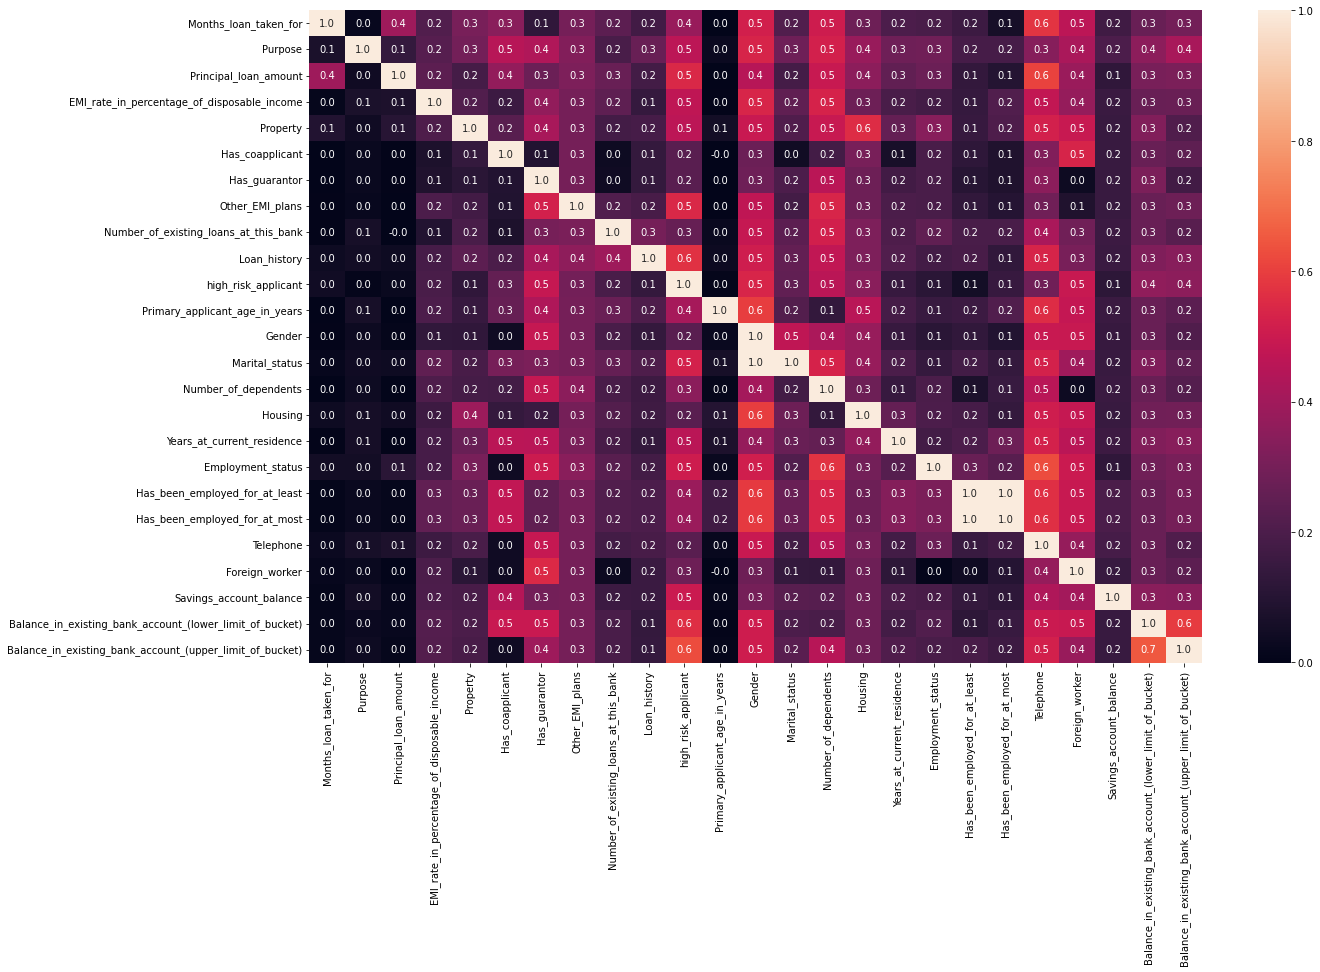

In [657]:
corr=correlation(data,categorical_feature,numerical_feature)
corr=pd.DataFrame(corr,columns=data.columns,index=data.columns)
plt.figure(figsize=(20,12))
sns.heatmap(corr,annot=True,fmt='.1f')
plt.show()

In [658]:
# converting this features to numerical
data.Has_been_employed_for_at_most=data.Has_been_employed_for_at_most.apply(lambda x:x if pd.isna(x) else int(x.strip()[0]))
data.Has_been_employed_for_at_least=data.Has_been_employed_for_at_least.apply(lambda x:x if pd.isna(x) else int(x.strip()[0]))

In [659]:
print('no.of data points : {}'.format(len(data)))

no.of data points : 1000


In [660]:
data.columns #features

Index(['Months_loan_taken_for', 'Purpose', 'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income', 'Property',
       'Has_coapplicant', 'Has_guarantor', 'Other_EMI_plans',
       'Number_of_existing_loans_at_this_bank', 'Loan_history',
       'high_risk_applicant', 'Primary_applicant_age_in_years', 'Gender',
       'Marital_status', 'Number_of_dependents', 'Housing',
       'Years_at_current_residence', 'Employment_status',
       'Has_been_employed_for_at_least', 'Has_been_employed_for_at_most',
       'Telephone', 'Foreign_worker', 'Savings_account_balance',
       'Balance_in_existing_bank_account_(lower_limit_of_bucket)',
       'Balance_in_existing_bank_account_(upper_limit_of_bucket)'],
      dtype='object')

In [661]:
print('no.of columns : {}'.format(len(data.columns)))

no.of columns : 25


In [662]:
numerical_features = [
    'Months_loan_taken_for',
    'Principal_loan_amount',
    'EMI_rate_in_percentage_of_disposable_income',
    'Number_of_existing_loans_at_this_bank',
    'Primary_applicant_age_in_years',
    'Number_of_dependents',
    'Years_at_current_residence',
    'Has_been_employed_for_at_least',
    'Has_been_employed_for_at_most']
categorical_features = [
 'Purpose',
 'Property',
 'Has_coapplicant',
 'Has_guarantor',
 'Other_EMI_plans',
 'Loan_history',
 'Gender',
 'Marital_status',
 'Housing',
 'Employment_status',
 'Telephone',
 'Foreign_worker',
 'Savings_account_balance',
 'Balance_in_existing_bank_account_(lower_limit_of_bucket)',
 'Balance_in_existing_bank_account_(upper_limit_of_bucket)']

In [663]:
print('numerical features : {}'.format(len(numerical_features)))
print('categorical features : {}'.format(len(categorical_features)))

numerical features : 9
categorical features : 15


## Filling Null Values

Other_EMI_plans \
Telephone \
Balance_in_existing_bank_account_(lower_limit_of_bucket) \
Balance_in_existing_bank_account_(upper_limit_of_bucket)

for these features used 'nan' as a category

In [664]:
# due to more nan values and commonsensical i am filling these values with a new category as 'nan'
data.Other_EMI_plans.fillna('NaN',inplace=True)  # lot of nan values so, considering it as a option
data.Telephone.fillna('NaN',inplace=True)       #  considering nan as a option
data['Balance_in_existing_bank_account_(lower_limit_of_bucket)'].fillna('NaN',inplace=True)  # considering nan as a option
data['Balance_in_existing_bank_account_(upper_limit_of_bucket)'].fillna('NaN',inplace=True)  # considering nan as a option

Has_been_employed_for_at_least \
Has_been_employed_for_at_most \
Purpose \
Property \
Savings_account_balance 

for these features using model based imputation

In [665]:
# to build robust model ,it is better to do train test split before any model imputation , so that we dont have data leakage

X=data.drop('high_risk_applicant',axis=1)
y=data['high_risk_applicant'].values

In [666]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=20)
print('shapes of train data {} {}'.format(X_train.shape,y_train.shape))
print('shapes of test data {} {}'.format(X_test.shape,y_test.shape))

shapes of train data (800, 24) (800,)
shapes of test data (200, 24) (200,)


In [667]:
s=StandardScaler()
X_train_numeric=s.fit_transform(X_train[numerical_features])
X_test_numeric=s.transform(X_test[numerical_features])

In [668]:
feature_order=[]
feature_order+=list(s.get_feature_names_out())

In [669]:
ordinal_features=[
    'Savings_account_balance',
    'Housing',
    'Balance_in_existing_bank_account_(lower_limit_of_bucket)',
    'Balance_in_existing_bank_account_(upper_limit_of_bucket)',
]
categorical_features =[
 'Purpose',
 'Property',
 'Has_coapplicant',
 'Has_guarantor',
 'Other_EMI_plans',
 'Loan_history',
 'Gender',
 'Marital_status',
 'Employment_status',
 'Telephone',
 'Foreign_worker']

In [670]:
ordinal_feature_order=[['Low', 'High', 'Medium', 'Very high'],   #Savings_account_balance
                       ['for free','rent','own'],                #Housing
                       ['0','NaN','2 lac'],                      #Balance_in_existing_bank_account_(lower_limit_of_bucket)
                       ['0','NaN','2 lac']                       #Balance_in_existing_bank_account_(upper_limit_of_bucket)
                      ]
ordinal=OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan,categories=ordinal_feature_order)
X_train_ordinal=ordinal.fit_transform(X_train[ordinal_features])
X_test_ordinal=ordinal.transform(X_test[ordinal_features])

In [671]:
ordinal.feature_names_in_

array(['Savings_account_balance', 'Housing',
       'Balance_in_existing_bank_account_(lower_limit_of_bucket)',
       'Balance_in_existing_bank_account_(upper_limit_of_bucket)'],
      dtype=object)

In [672]:
feature_order+=list(ordinal.feature_names_in_)

In [673]:
onehot=OneHotEncoder(sparse=False)
X_train_cat=onehot.fit_transform(X_train[categorical_features])
X_test_cat=onehot.transform(X_test[categorical_features])

In [674]:
feature_order+=list(onehot.get_feature_names_out())

In [675]:
X_train_final=np.hstack([X_train_numeric,X_train_ordinal,X_train_cat])
X_test_final=np.hstack([X_test_numeric,X_test_ordinal,X_test_cat])
imputer=KNNImputer(n_neighbors=3)
X_train_final=imputer.fit_transform(X_train_final,y_train)
X_test_final=imputer.transform(X_test_final)

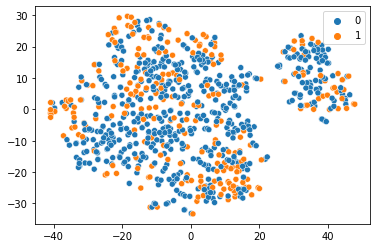

In [676]:
t=TSNE()
val=t.fit_transform(X_train_final,2)
sns.scatterplot(val[:,0],val[:,1],hue=y_train)
plt.show()

too much overlab better to do feature selection

### features selection

In [677]:
model=SequentialFeatureSelector(DecisionTreeClassifier(class_weight='balanced'),n_features_to_select=10,scoring='f1',cv=5)
model.fit(X_train_final,y_train)
important_fetures=list(model.get_feature_names_out(list(range(len(feature_order)))))
model.get_feature_names_out(feature_order)  #important features

array(['Balance_in_existing_bank_account_(lower_limit_of_bucket)',
       'Balance_in_existing_bank_account_(upper_limit_of_bucket)',
       'Purpose_business', 'Purpose_career development', 'Purpose_nan',
       'Property_building society savings agreement/life insurance',
       'Property_real estate', 'Marital_status_divorced/separated',
       'Foreign_worker_0', 'Foreign_worker_1'], dtype=object)

### Random forest

+---------------+-----------+-----------+--------+----------+
|     model     | max_depth | threshold | recall | f1_score |
+---------------+-----------+-----------+--------+----------+
| Random Forest |     6     |    0.5    |  0.82  |   0.6    |
| Random Forest |     6     |    0.3    |  0.82  |   0.59   |
| Random Forest |     6     |    0.2    |  1.0   |   0.47   |
+---------------+-----------+-----------+--------+----------+


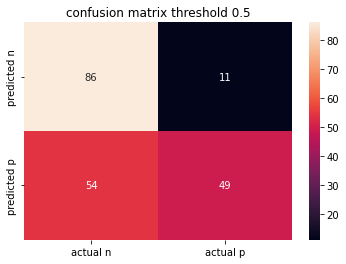

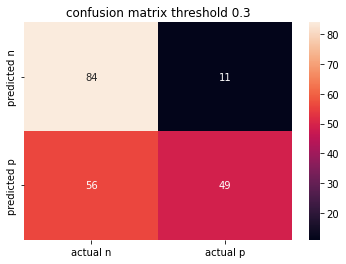

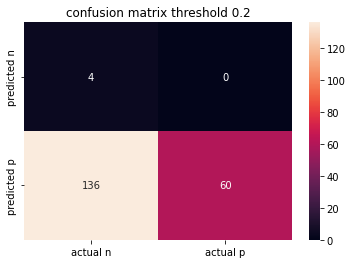

In [646]:
def performance(y_true,y_pred,thre):
    y_pred=(y_pred[:,1]>thre).astype(int)
    recall=recall_score(y_true,y_pred)
    f1=f1_score(y_true,y_pred)
    return recall,f1
m=RandomForestClassifier(class_weight='balanced')
para={
    'n_estimators':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'max_depth':[3,4,5,6,7,8,9,10],
    'min_samples_split':[3,4,5,6,7,8],
    'min_samples_leaf' :[2,3,4,5,6,7,8]
}
grid=GridSearchCV(m,para,scoring='recall',n_jobs=-1,cv=5)
grid.fit(X_train_final[:,important_fetures],y_train)
pred_train=grid.predict_proba(X_train_final[:,important_fetures])
pred_test=grid.predict_proba(X_test_final[:,important_fetures])
recall,f1=performance(y_test,pred_test,0.5)
t=prettytable.PrettyTable()
t.field_names=['model','max_depth','threshold','recall','f1_score']
t.add_row(['Random Forest',grid.best_params_['max_depth'],0.5,recall.round(2),f1.round(2)])
recall,f1=performance(y_test,pred_test,0.3)
t.add_row(['Random Forest',grid.best_params_['max_depth'],0.3,recall.round(2),f1.round(2)])
recall,f1=performance(y_test,pred_test,0.2)
t.add_row(['Random Forest',grid.best_params_['max_depth'],0.2,recall.round(2),f1.round(2)])
print(t)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,pred_test[:,1].round(0)).T,columns=['actual n','actual p'],index=['predicted n','predicted p']),annot=True,fmt='d')
plt.title('confusion matrix threshold 0.5')
plt.show()
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,(pred_test[:,1]>0.3).astype(int)).T,columns=['actual n','actual p'],index=['predicted n','predicted p']),annot=True,fmt='d')
plt.title('confusion matrix threshold 0.3')
plt.show()
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,(pred_test[:,1]>0.2).astype(int)).T,columns=['actual n','actual p'],index=['predicted n','predicted p']),annot=True,fmt='d')
plt.title('confusion matrix threshold 0.2')
plt.show()

### Decision Tree

+---------------+-----------+-----------+--------+----------+
|     model     | max_depth | threshold | recall | f1_score |
+---------------+-----------+-----------+--------+----------+
| Decision Tree |     7     |    0.5    |  0.8   |   0.6    |
| Decision Tree |     7     |    0.3    |  0.87  |   0.6    |
| Decision Tree |     7     |    0.2    |  0.97  |   0.48   |
+---------------+-----------+-----------+--------+----------+


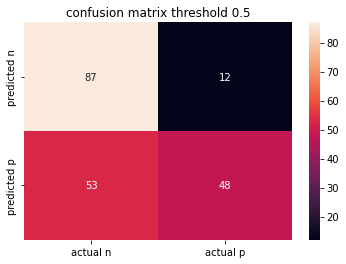

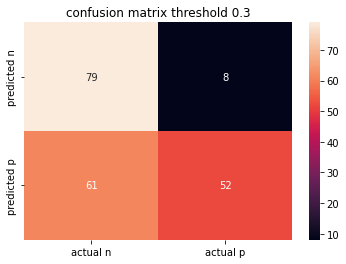

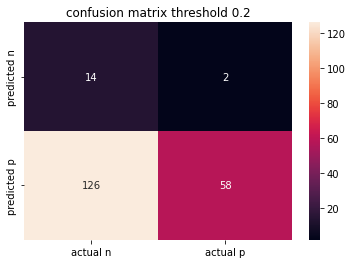

In [678]:
m=DecisionTreeClassifier(class_weight='balanced')
para={
    'max_depth':[3,4,5,6,7,8,9,10],
    'min_samples_split':[3,4,5,6,7,8],
    'min_samples_leaf' :[2,3,4,5,6,7,8]
}
grid=GridSearchCV(m,para,scoring='f1',n_jobs=-1,cv=5)
grid.fit(X_train_final[:,important_fetures],y_train)
pred_train=grid.predict_proba(X_train_final[:,important_fetures])
pred_test=grid.predict_proba(X_test_final[:,important_fetures])
recall,f1=performance(y_test,pred_test,0.5)
t=prettytable.PrettyTable()
t.field_names=['model','max_depth','threshold','recall','f1_score']
t.add_row(['Decision Tree',grid.best_params_['max_depth'],0.5,recall.round(2),f1.round(2)])
recall,f1=performance(y_test,pred_test,0.3)
t.add_row(['Decision Tree',grid.best_params_['max_depth'],0.3,recall.round(2),f1.round(2)])
recall,f1=performance(y_test,pred_test,0.2)
t.add_row(['Decision Tree',grid.best_params_['max_depth'],0.2,recall.round(2),f1.round(2)])
print(t)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,pred_test[:,1].round(0)).T,columns=['actual n','actual p'],index=['predicted n','predicted p']),annot=True,fmt='d')
plt.title('confusion matrix threshold 0.5')
plt.show()
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,(pred_test[:,1]>0.3).astype(int)).T,columns=['actual n','actual p'],index=['predicted n','predicted p']),annot=True,fmt='d')
plt.title('confusion matrix threshold 0.3')
plt.show()
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,(pred_test[:,1]>0.2).astype(int)).T,columns=['actual n','actual p'],index=['predicted n','predicted p']),annot=True,fmt='d')
plt.title('confusion matrix threshold 0.2')
plt.show()

## Model Deployment

In [679]:
# we can deploy model using flask ,like this , this is not final , we can optimize furture by only considering important features
# this is just for intution ,

from flask import Flask,request
app = Flask(__name__)
@app.route("/",methods=['post'])
def predict():
    query=request.form['id']   # need to send list data in form or json 
    num=s.transform(query[numerical_feature])           #numerical preprocessing
    ordi=ordinal.transform(query[ordinal_features])     #ordinal preprocessing
    cat=onehot.transform(query[categorical_feature])    #categorical preprocessing
    final=np.hstack([num,ordi,cat])
    label=m.predict(final[important_fetures])           #we can use threshold here
    return {'high_risk_applicant':label}